In [1]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from wordcloud import WordCloud
from collections import Counter
import squarify
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Specify the input file
input_file = '../data/data_clustered.csv'

# Load the clustered data
df = pd.read_csv(input_file)

# Print the first 5 rows
df.head()

update_date                                               text  \
0  2022-03-31  convergence discrete dipole approximation theo...   
1  2022-03-30  discrete dipole approximation overview develop...   
2  2021-10-15  mapping radius metric space every closed curve...   
3  2019-08-19  remnant evolution carbon oxygen white dwarf me...   
4  2019-08-19  cofibrations category frolicher space cofibrat...   

                         categories_list  num_categories  cluster  
0  ['physics.optics', 'physics.comp-ph']               2        3  
1  ['physics.optics', 'physics.comp-ph']               2        0  
2                            ['math.MG']               1        5  
3                           ['astro-ph']               1        6  
4                            ['math.AT']               1        5

In [23]:
# save sample of data in a new csv file
df_sample = df.sample(n=1000)
df_sample.to_csv('../data/clustered_data_sample.csv', index=False)

In [7]:
# Convert 'update_date' to datetime data type
df['update_date'] = pd.to_datetime(df['update_date'])

# Convert 'categories_list' to an actual list
df['categories_list'] = df['categories_list'].apply(ast.literal_eval)

# cluster number plus 1
df['cluster'] = df['cluster'] + 1

# Verify the changes
df.dtypes, df.head()

(update_date        datetime64[ns]
 text                       object
 categories_list            object
 num_categories              int64
 cluster                     int64
 dtype: object,
   update_date                                               text  \
 0  2022-03-31  convergence discrete dipole approximation theo...   
 1  2022-03-30  discrete dipole approximation overview develop...   
 2  2021-10-15  mapping radius metric space every closed curve...   
 3  2019-08-19  remnant evolution carbon oxygen white dwarf me...   
 4  2019-08-19  cofibrations category frolicher space cofibrat...   
 
                      categories_list  num_categories  cluster  
 0  [physics.optics, physics.comp-ph]               2        4  
 1  [physics.optics, physics.comp-ph]               2        1  
 2                          [math.MG]               1        6  
 3                         [astro-ph]               1        7  
 4                          [math.AT]               1        6  )

## General information

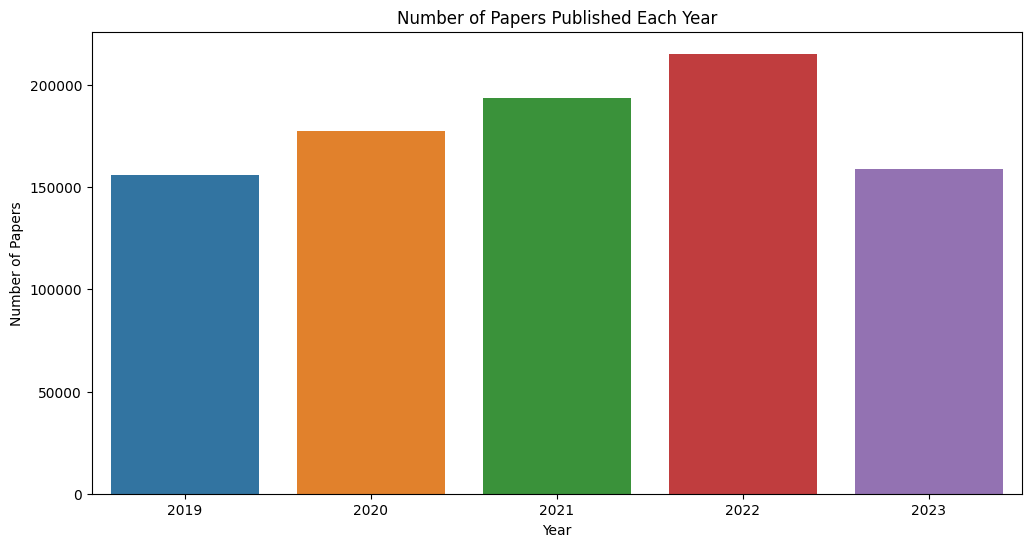

In [8]:
# Extract the year from the 'update_date' column
df['year'] = df['update_date'].dt.year

# Plot the number of papers published each year
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='year', order=df['year'].sort_values().unique())
plt.title('Number of Papers Published Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.savefig('../images/analysis/number_of_papers_published_each_year.png')
plt.show()

In [26]:
# Calculate the number of papers in each cluster for each year
cluster_popularity_table = df.groupby(['year', 'cluster']).size().reset_index(name='num_papers')

# Calculate the year-over-year percentage change in the number of papers for each cluster
cluster_popularity_table['percent_change'] = cluster_popularity_table.groupby('cluster')['num_papers'].pct_change() * 100

# Filter out the incomplete data for the year 2023
cluster_popularity_table_filtered = cluster_popularity_table[cluster_popularity_table['year'] == 2022]

# Show the table for cluster popularity
cluster_popularity_table_filtered


year  cluster  num_papers  percent_change
24  2022        1       12104        6.840851
25  2022        2       12792       20.998865
26  2022        3       42733       19.332589
27  2022        4       58668        9.885746
28  2022        5       14355       11.374040
29  2022        6       37331       12.585198
30  2022        7       10649        5.133774
31  2022        8       26588        1.079684

In [27]:
from collections import Counter

# Flatten the list of categories and count the occurrences of each category
all_categories = [category for sublist in df['categories_list'] for category in sublist]
category_counter = Counter(all_categories)

# Convert to DataFrame for easier manipulation and plotting
category_df = pd.DataFrame.from_dict(category_counter, orient='index', columns=['count']).reset_index()
category_df.rename(columns={'index': 'category'}, inplace=True)
category_df = category_df.sort_values('count', ascending=False)

top_5_categories = category_df.head(5)['category'].tolist()

# Calculate the number of papers in each category for each year
category_popularity_table = df.explode('categories_list').groupby(['year', 'categories_list']).size().reset_index(name='num_papers')

# Calculate the year-over-year percentage change in the number of papers for each category
category_popularity_table['percent_change'] = category_popularity_table.groupby('categories_list')['num_papers'].pct_change() * 100

# Filter out the incomplete data for the year 2023
category_popularity_table_filtered = category_popularity_table[category_popularity_table['year'] == 2022]

# Show the table for top categories' popularity
top_categories_popularity_table = category_popularity_table_filtered[category_popularity_table_filtered['categories_list'].isin(top_5_categories)]
top_categories_popularity_table

year categories_list  num_papers  percent_change
522  2022           cs.AI       15403       32.933460
529  2022           cs.CV       20946       22.298126
544  2022           cs.LG       31629       17.606158
655  2022        quant-ph       12839       22.171472
659  2022         stat.ML        6741      -12.794308

In [28]:
# Function to generate combinations of categories for each paper
def generate_combinations(categories_list):
    return list(combinations(categories_list, 2))

# Generate combinations of categories for each paper
df['category_combinations'] = df['categories_list'].apply(generate_combinations)

# Explode the DataFrame to have one row per category combination per paper
exploded_combinations_df = df.explode('category_combinations')

# Count the frequency of each category combination
category_cooccurrence = exploded_combinations_df.groupby('category_combinations').size().reset_index(name='frequency')

# Sort by frequency and show the top 10 most frequent category combinations
top_10_cooccurrence = category_cooccurrence.sort_values(by='frequency', ascending=False).head(10)
top_10_cooccurrence


category_combinations  frequency
3688      (cs.LG, stat.ML)      29951
6133    (math-ph, math.MP)      23419
3483      (cs.IT, math.IT)      17822
2195        (cs.CV, cs.LG)      17413
3556        (cs.LG, cs.AI)      13935
1446        (cs.AI, cs.LG)      12616
7663      (math.NA, cs.NA)      12474
5586      (eess.SY, cs.SY)      10220
8482    (math.ST, stat.TH)       9853
1973        (cs.CL, cs.LG)       8884

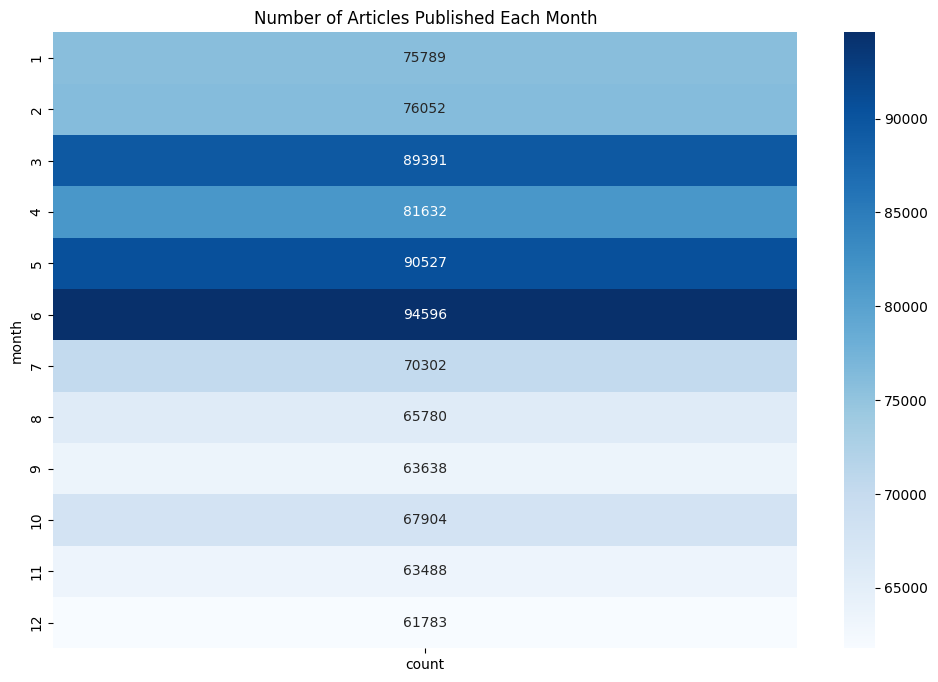

In [29]:
# Analyze the distribution of articles by month and plot them in a heatmap without considering the year
df['month'] = pd.to_datetime(df['update_date']).dt.month
month_counts = df['month'].value_counts().sort_index()
# Convert the series to a dataframe
month_counts = month_counts.to_frame()
month_counts.columns = ['count']

# show the distribution of articles by month in a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(month_counts, annot=True, fmt='g', cmap='Blues')
plt.title('Number of Articles Published Each Month')
plt.savefig('../images/analysis/number_of_articles_published_each_month.png')
plt.show()


## Categories analysis

In [30]:
# Calculate the number of papers in each category for each year
category_year_count = df.explode('categories_list').groupby(['year', 'categories_list']).size().reset_index(name='num_papers')

# Calculate the year-over-year percentage change in the number of papers for each category
category_year_count['percent_change'] = category_year_count.groupby('categories_list')['num_papers'].pct_change() * 100

# Filter out the incomplete data for the year 2023 and categories with fewer than a threshold number of papers
threshold = 500
category_year_count_filtered = category_year_count[(category_year_count['year'] > 2021) & (category_year_count['num_papers'] > threshold)]

# Find categories with significant year-over-year percentage increase (greater than 20%)
significant_increase_categories = category_year_count_filtered[category_year_count_filtered['percent_change'] > 20]

# Show the categories with significant increase but fewer articles
significant_increase_categories.sort_values(by='percent_change', ascending=False).head(20)


year categories_list  num_papers  percent_change
564  2022         econ.TH         608       48.655257
522  2022           cs.AI       15403       32.933460
539  2022           cs.GR         980       30.492676
614  2022  physics.acc-ph         630       30.165289
578  2022         math.AT        1609       29.133226
570  2022          hep-ex        3759       28.425009
565  2022         eess.AS        3090       28.162588
604  2022         math.SG         764       27.333333
558  2022           cs.SD        2765       27.009646
562  2022         econ.EM         730       26.079447
581  2022         math.CT         963       26.047120
658  2022         stat.ME        3994       25.993691
547  2022           cs.MM         923       25.067751
576  2022         math.AG        4470       25.000000
705  2023           cs.LO        1673       23.925926
605  2022         math.SP         822       23.609023
523  2022           cs.AR         825       22.950820
606  2022         math.ST        2505       22.613803
661  2022         stat.TH        2505       22.613803
529  2022           cs.CV       20946       22.298126

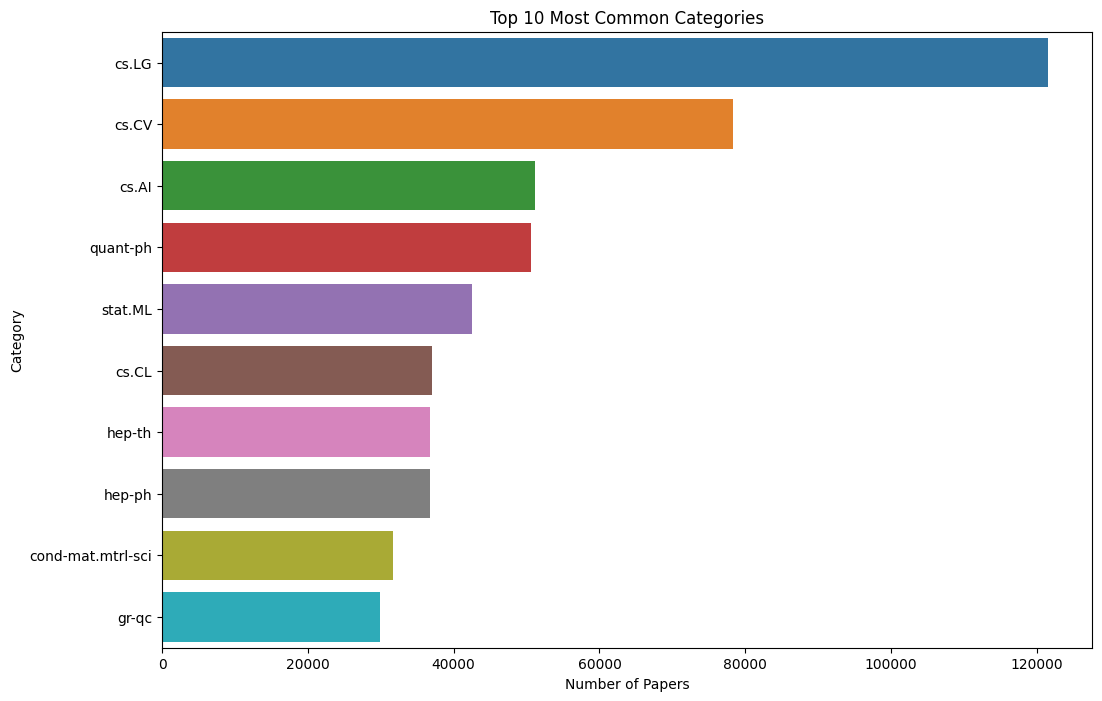

In [31]:
# Flatten the list of categories and count the occurrences of each category
all_categories = [category for sublist in df['categories_list'] for category in sublist]
category_counter = Counter(all_categories)

# Convert to DataFrame for easier manipulation and plotting
category_df = pd.DataFrame.from_dict(category_counter, orient='index', columns=['count']).reset_index()
category_df.rename(columns={'index': 'category'}, inplace=True)
category_df = category_df.sort_values('count', ascending=False)

# Plot the top 10 most common categories
plt.figure(figsize=(12, 8))
sns.barplot(data=category_df.head(10), x='count', y='category')
plt.title('Top 10 Most Common Categories')
plt.xlabel('Number of Papers')
plt.ylabel('Category')
plt.savefig('../images/analysis/top_10_most_common_categories.png')
plt.show()


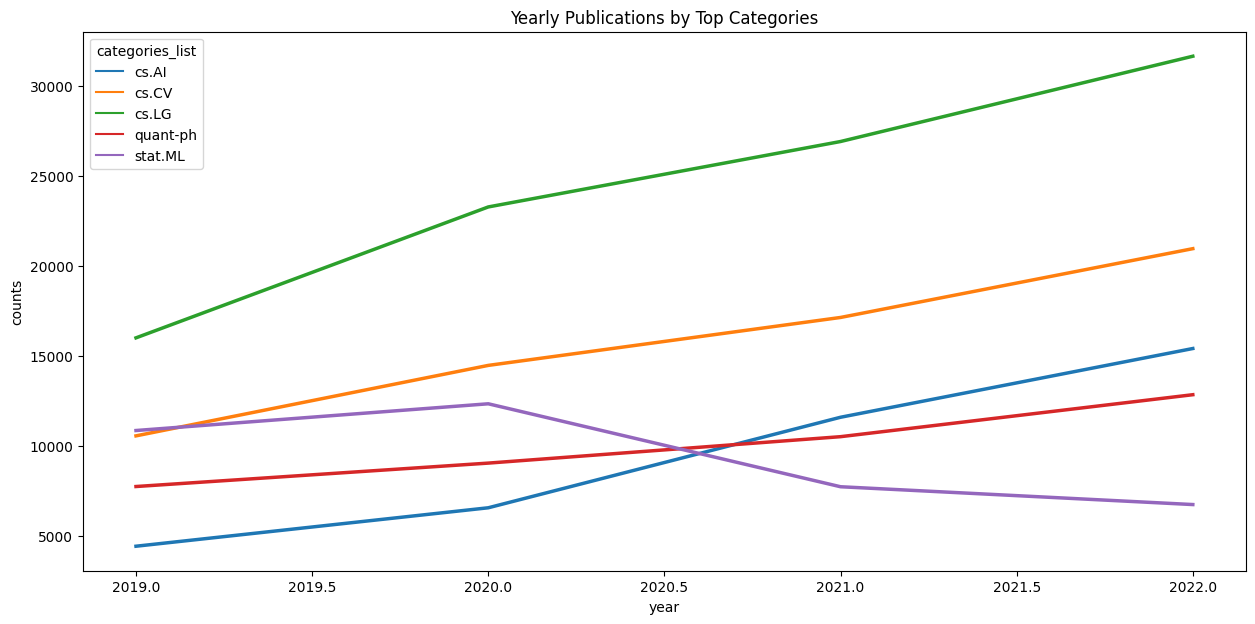

In [32]:
# Split the categories and explode the DataFrame to have one category per row
df_categories = df.assign(categories=df['categories_list'].str.split(' ')).explode('categories_list')

# Group by year and category, then count the number of articles
category_yearly_counts = df_categories.groupby(['year', 'categories_list']).size().reset_index(name='counts')

# Plot the top N categories
N = 5
top_categories = category_yearly_counts.groupby('categories_list')['counts'].sum().nlargest(N).index
filtered_counts = category_yearly_counts[category_yearly_counts['categories_list'].isin(top_categories)]

# Filter to only include rows where the year is before 2023
filtered_counts_before_2023 = filtered_counts[filtered_counts['year'] < 2023]


plt.figure(figsize=(15, 7))
sns.lineplot(data=filtered_counts_before_2023, x='year', y='counts', hue='categories_list', palette='tab10', linewidth=2.5)
plt.title('Yearly Publications by Top Categories')
plt.savefig('../images/analysis/yearly_publications_by_top_categories.png')
plt.show()


## Cluster analysis

In [50]:
# print number of articles in each cluster in a df
cluster_counts = df['cluster'].value_counts().to_frame()
cluster_counts.columns = ['count']
cluster_counts

count
cluster        
4        241687
3        161005
6        158173
8        121245
5         66075
1         52304
2         51043
7         49350

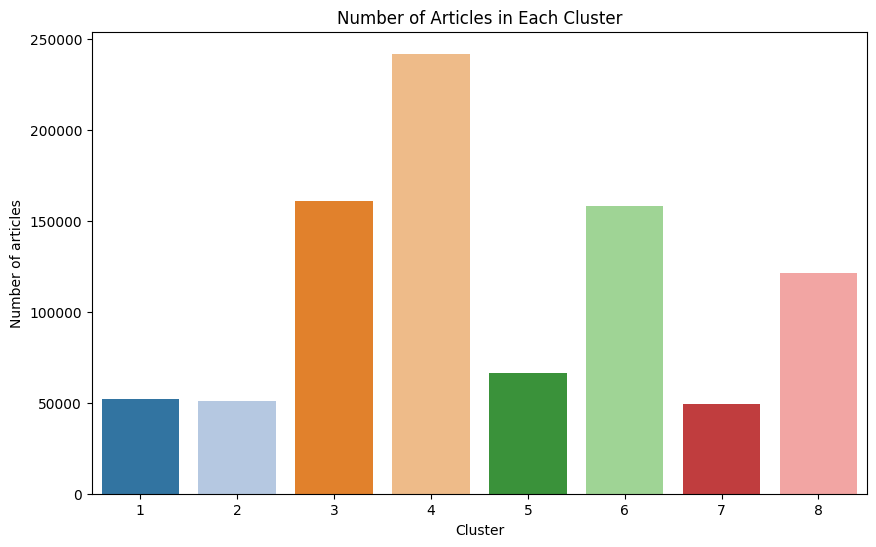

In [42]:
# 1. Distribution of Data Points in Clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cluster', palette='tab20')
plt.title('Number of Articles in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of articles')
plt.savefig('../images/analysis/cluster_distribution.png')
plt.show()

<Figure size 1400x900 with 0 Axes>

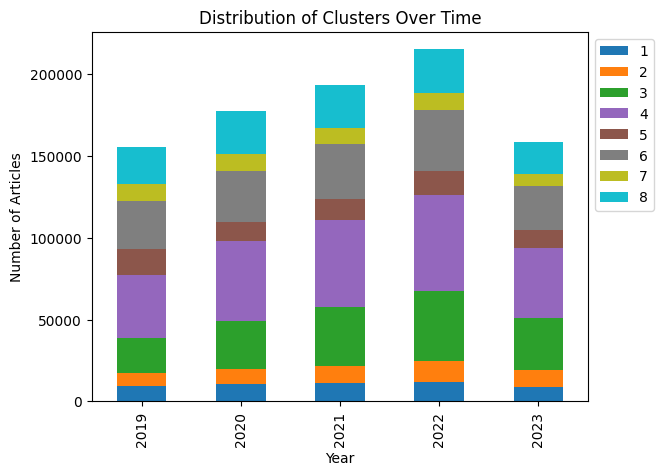

In [33]:
# Extract the year from the 'update_date' column
df['year'] = pd.to_datetime(df['update_date']).dt.year

# Analyze the distribution of articles over time
year_counts = df['year'].value_counts().sort_index()

# Analyze the distribution of clusters over time
cluster_year_counts = df.groupby('year')['cluster'].value_counts()

# Plot the distribution of clusters in each year as a stacked bar chart
plt.figure(figsize=(14, 9))
cluster_year_counts.unstack().plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Distribution of Clusters Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.savefig('../images/analysis/distribution_of_clusters_over_time.png')
plt.show()


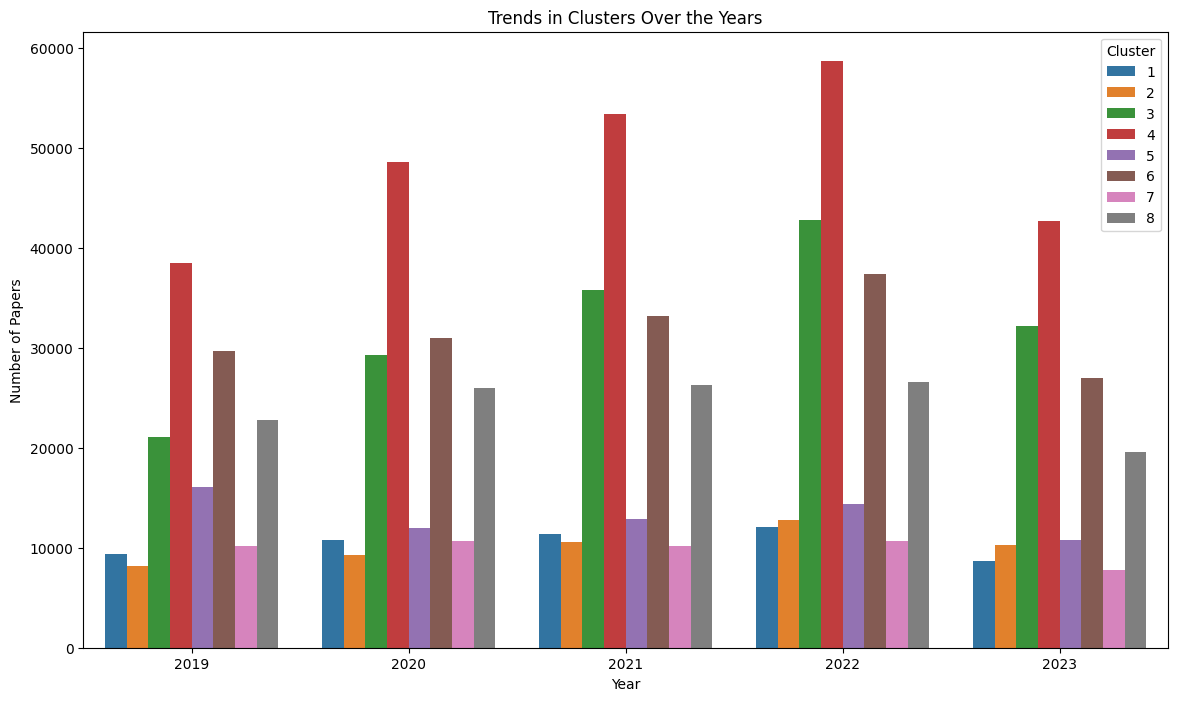

In [34]:
# Count the occurrences of each cluster for each year
cluster_year_count = df.groupby(['year', 'cluster']).size().reset_index(name='count')

# Plot the trends for each cluster over the years using a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_year_count, x='year', y='count', hue='cluster')
plt.title('Trends in Clusters Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.legend(title='Cluster')
plt.savefig('../images/analysis/trends_in_clusters_over_the_years.png')
plt.show()


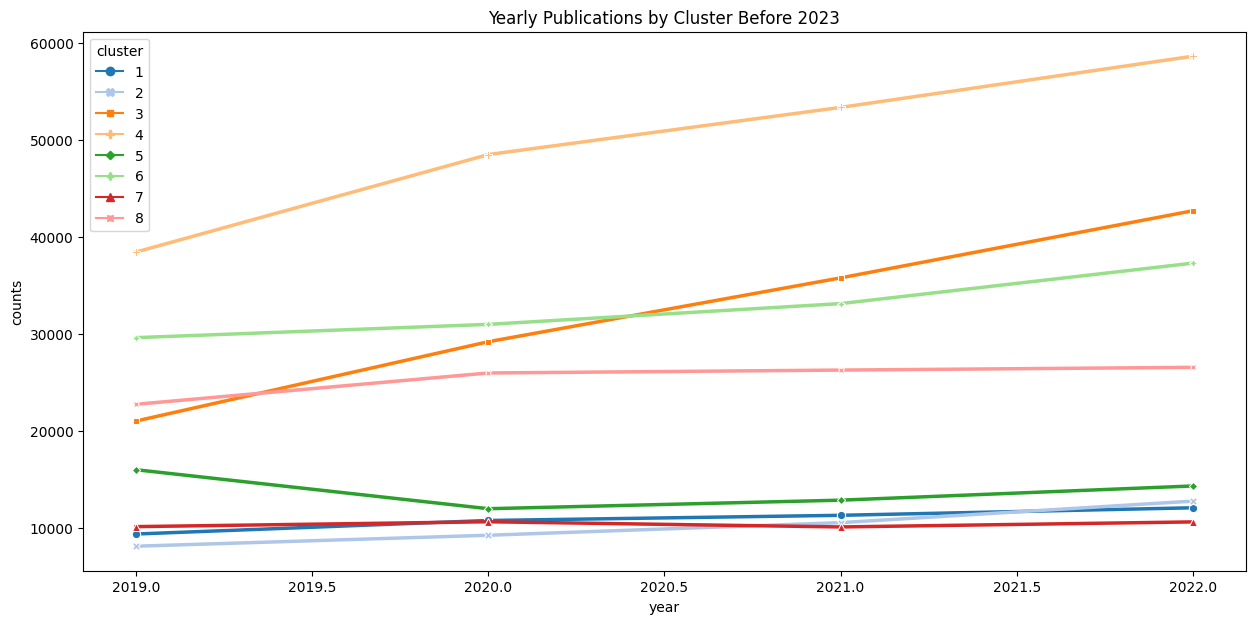

In [36]:
# Group by year and cluster, then count the number of articles
cluster_popularity = df.groupby(['year', 'cluster']).size().reset_index(name='counts')

# Filter to only include rows where the year is before 2023
cluster_popularity_before_2023 = cluster_popularity[cluster_popularity['year'] < 2023]

# Plot the filtered data
plt.figure(figsize=(15, 7))
sns.lineplot(data=cluster_popularity_before_2023, x='year', y='counts', hue='cluster', palette='tab20', linewidth=2.5, style='cluster', markers=True, dashes=False)
plt.title('Yearly Publications by Cluster Before 2023')
plt.savefig('../images/analysis/yearly_publications_by_cluster_before_2023.png')
plt.show()

In [4]:
def get_top_n_terms(texts, top_n=10):
    """Return the top n terms (most frequent) in a set of texts"""
    # Initialize an empty list to store the terms
    all_terms = []

    # Iterate over the texts
    for text in texts:
        # Split text into tokens (words), remove punctuation and convert to lowercase
        tokens = [word.strip('.,;:!?()[]{}`''\"') for word in text.lower().split()]
        # Add the tokens to the list
        all_terms += tokens

    # Get the top n terms
    top_terms = Counter(all_terms).most_common(top_n)

    return top_terms

def top_terms_per_cluster(texts, clusters, top_n=20):
    """Return the top n terms in each cluster"""
    # Initialize an empty dictionary to store the top terms per cluster
    cluster_top_terms = dict()

    # Iterate over clusters
    for cluster_num in range(max(clusters) + 1):
        # Get the indices of texts that belong to the current cluster
        mask = (clusters == cluster_num)
        # Get the texts that belong to the current cluster
        cluster_texts = texts[mask]
        # Get the top n terms in this cluster
        top_terms = get_top_n_terms(cluster_texts, top_n=top_n)
        # Store the top terms per cluster
        cluster_top_terms[cluster_num] = top_terms

    return cluster_top_terms


cluster_top_terms = top_terms_per_cluster(df['text'], df['cluster'])

for cluster_num, top_terms in cluster_top_terms.items():
    print(f"Cluster {cluster_num}: {[term for term, count in top_terms]}")



Cluster 0: ['equation', 'solution', 'space', 'differential', 'boundary', 'nonlinear', 'field', 'wave', 'linear', 'dimensional', 'flow', 'stochastic', 'existence', 'condition', 'energy', 'dynamic', 'scheme', 'data', 'estimate', 'mathbb']
Cluster 1: ['quantum', 'state', 'ical', 'field', 'entanglement', 'spin', 'algorithm', 'photon', 'information', 'circuit', 'dynamic', 'qubit', 'energy', 'space', 'interaction', 'gate', 'error', 'protocol', 'dimensional', 'p']
Cluster 2: ['learning', 'network', 'data', 'image', 'neural', 'training', 'deep', 'task', 'dataset', 'information', 'datasets', 'domain', 'detection', 'language', 'ification', 'feature', 'object', 'multi', 'trained', 'accuracy']
Cluster 3: ['data', 'algorithm', 'network', 'learning', 'information', 'user', 'control', 'distribution', 'optimization', 'dynamic', 'rate', 'multi', 'agent', 'application', 'ing', 'linear', 'error', 'power', 'estimation', 'communication']
Cluster 4: ['energy', 'mass', 'matter', 'dark', 'black', 'hole', 'fie

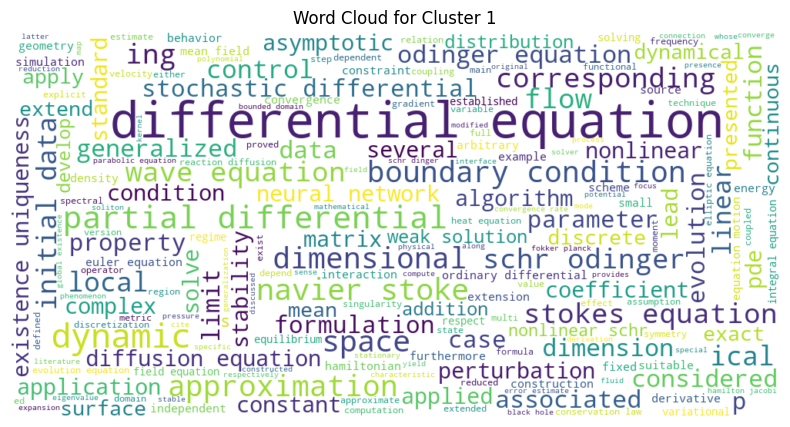

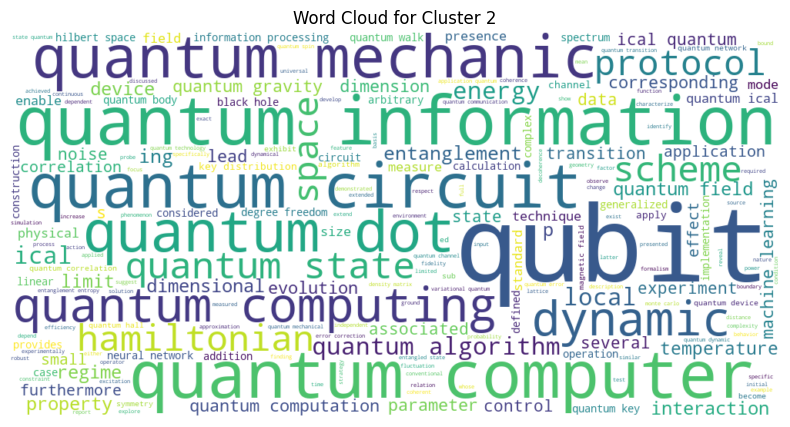

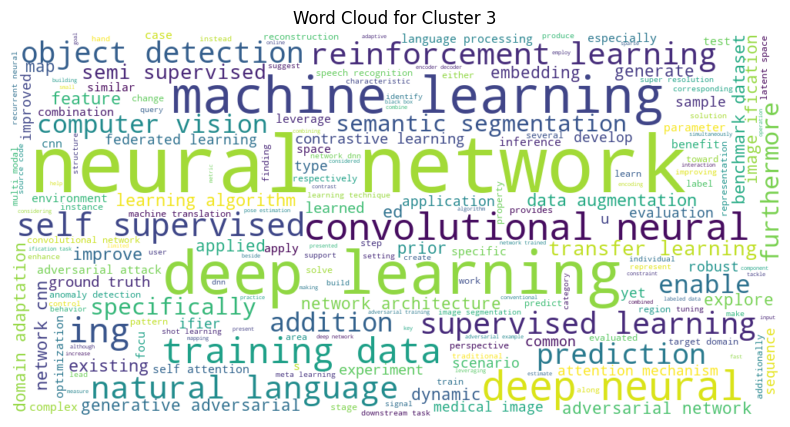

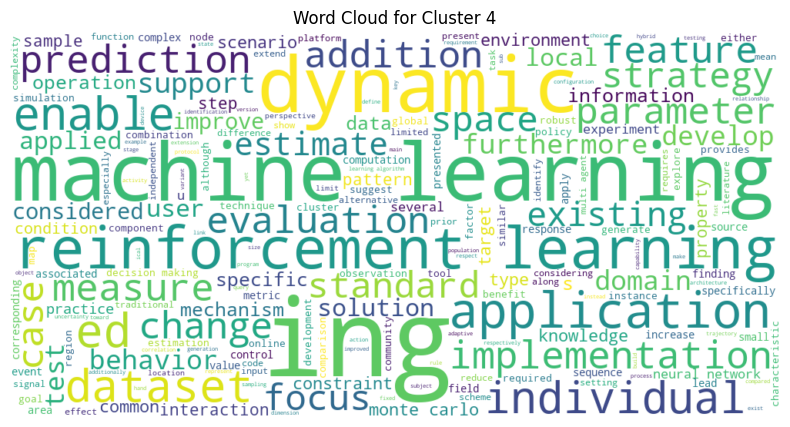

In [37]:
# Sort unique cluster numbers
sorted_clusters = sorted(df['cluster'].unique())

# Generate word clouds for each sorted cluster number
for cluster_num in sorted_clusters:
    cluster_text = ' '.join(df[df['cluster'] == cluster_num]['text'])
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(cluster_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.savefig(f'../images/analysis/word_cloud_for_cluster_{cluster_num}.png')
    plt.show()


In [19]:
# Extract the year from 'update_date' column
df['year'] = pd.to_datetime(df['update_date']).dt.year+1

# Filter data for years before 2023
df_filtered = df[df['year'] < 2024]

# Group by 'year' and 'cluster' and count the size
cluster_popularity = df_filtered.groupby(['year', 'cluster']).size().reset_index(name='counts')

# Calculate the year-on-year growth for each cluster
cluster_popularity['yearly_growth'] = cluster_popularity.groupby('cluster')['counts'].pct_change() * 100

# Plot the data
plt.figure(figsize=(15, 7))
sns.lineplot(data=cluster_popularity, x='year', y='yearly_growth', hue='cluster', palette='tab20', linewidth=2.5)
plt.title('Yearly Growth Rate of Clusters')
plt.savefig('../images/analysis/yearly_growth_rate_of_clusters.png')
plt.show()

In [20]:
# Create a DataFrame to store cluster, category, and year information
cluster_category_year_df = df.explode('categories_list')[['cluster', 'categories_list', 'year']]

# Group by year, cluster, and category to get the count of papers
cluster_category_year_count = cluster_category_year_df.groupby(['year', 'cluster', 'categories_list']).size().reset_index(name='count')

# Filter data for the latest year
latest_year = cluster_category_year_count['year'].max()
latest_year_data = cluster_category_year_count[cluster_category_year_count['year'] == latest_year]
unique_clusters = latest_year_data['cluster'].unique()

# Initialize the figure
fig, axs = plt.subplots(3, 3, figsize=(18, 18))
axs = axs.flatten()

# Create pie charts for each cluster
for idx, cluster in enumerate(unique_clusters):
    ax = axs[idx]
    
    # Filter data for the current cluster
    cluster_data = latest_year_data[latest_year_data['cluster'] == cluster]
    
    # Get the top 3 categories and the rest
    top_3_categories = cluster_data.nlargest(3, 'count')
    rest_categories = cluster_data.loc[~cluster_data.index.isin(top_3_categories.index)]
    rest_count = rest_categories['count'].sum()
    
    # Prepare data for pie chart
    pie_data = pd.concat([top_3_categories, pd.DataFrame({'categories_list': ['Others'], 'count': [rest_count]})])
    
    # Create the pie chart
    ax.pie(pie_data['count'], labels=pie_data['categories_list'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Distribution of Papers in Cluster {cluster} for Year {latest_year}')

# Hide any unused subplots
for idx in range(len(unique_clusters), 9):
    axs[idx].axis('off')

plt.tight_layout()
plt.savefig('../images/analysis/distribution_of_papers_in_each_cluster.png')
plt.show()


In [46]:
most_recent_year = 2023

# Explode the DataFrame to have one row per category per paper
exploded_df = df.explode('categories_list')

# Find the top 3 categories for each cluster for the earliest and most recent years
earliest_year = 2018  # Based on the data we have

# Filter data for the earliest and most recent complete years
earliest_data = exploded_df[exploded_df['year'] == earliest_year]
latest_data = exploded_df[exploded_df['year'] == most_recent_year]

# Find the top 3 categories for each cluster for the earliest year
top_3_earliest = earliest_data.groupby(['cluster', 'categories_list']).size().reset_index(name='count').sort_values(['cluster', 'count'], ascending=[True, False])
top_3_earliest = top_3_earliest.groupby('cluster').head(3)

# Find the top 3 categories for each cluster for the most recent year
top_3_latest = latest_data.groupby(['cluster', 'categories_list']).size().reset_index(name='count').sort_values(['cluster', 'count'], ascending=[True, False])
top_3_latest = top_3_latest.groupby('cluster').head(3)

# Combine the two DataFrames for comparison
top_3_earliest['year'] = earliest_year
top_3_latest['year'] = most_recent_year
cluster_shifts = pd.concat([top_3_earliest, top_3_latest], ignore_index=True)

cluster_shifts


cluster    categories_list  count  year
0         1            math.AP   2689  2023
1         1            math.NA   1476  2023
2         1              cs.NA   1459  2023
3         2           quant-ph   7533  2023
4         2             hep-th   1193  2023
5         2  cond-mat.mes-hall    976  2023
6         3              cs.LG  13865  2023
7         3              cs.CV  13611  2023
8         3              cs.AI   7964  2023
9         4              cs.LG   8745  2023
10        4              cs.AI   4893  2023
11        4            math.OC   3272  2023
12        5             hep-ph   4977  2023
13        5              gr-qc   3121  2023
14        5             hep-th   2257  2023
15        6            math.CO   4258  2023
16        6            math.AG   3018  2023
17        6            math.NT   2566  2023
18        7        astro-ph.GA   3783  2023
19        7        astro-ph.HE   2316  2023
20        7        astro-ph.SR   2214  2023
21        8  cond-mat.mtrl-sci   4620  2023
22        8  cond-mat.mes-hall   3345  2023
23        8    cond-mat.str-el   2520  2023

In [43]:
# Find the top 10 categories for each year
top_10_categories_by_year = exploded_df.groupby(['year', 'categories_list']).size().reset_index(name='count').sort_values(['year', 'count'], ascending=[True, False])
top_10_categories_by_year = top_10_categories_by_year.groupby('year').head(10)

# Identify categories that have consistently been in the top 10
consistent_top_categories = top_10_categories_by_year['categories_list'].value_counts().reset_index()
consistent_top_categories.columns = ['categories_list', 'years_in_top_10']

# Filter for categories that have been in the top 10 for all years
consistent_top_categories = consistent_top_categories[consistent_top_categories['years_in_top_10'] > 4]  # We have data for 5 years

consistent_top_categories


categories_list  years_in_top_10
0              cs.LG                5
1            stat.ML                5
2              cs.CV                5
3           quant-ph                5
4             hep-ph                5
5             hep-th                5
6  cond-mat.mtrl-sci                5